### **Laboratorio 2**

### **Carga de Datos de Importacion Hidrocarburos**

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras


#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### **Datos de Importacion** 

In [185]:
df_import_2024 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx", skiprows=6)
df_import_2025 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx", skiprows=6)

print(df_import_2024.columns.tolist())

['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras', 'Combustible turbo jet', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior', 'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas', 'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano', 'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido', 'Total importación']


In [186]:

df_import_2024["Diesel"] = df_import_2024["Diesel alto azufre"] + df_import_2024["Diesel bajo azufre"]
df_import_2025["Diesel"] = df_import_2025["Diesel bajo azufre"]


In [187]:

columnas_deseadas = [
    "Fecha",
    "Gasolina Regular",
    "Gasolina Superior",
    "Diesel",
    "Gas Licuado De Petróleo"
]


df_import_2024.columns = df_import_2024.columns.str.strip().str.title()
df_import_2025.columns = df_import_2025.columns.str.strip().str.title()


df_2024_cols = df_import_2024[columnas_deseadas].copy()
df_2025_cols = df_import_2025[columnas_deseadas].copy()


df_total = pd.concat([df_2024_cols, df_2025_cols], ignore_index=True)


df_total["Fecha"] = pd.to_datetime(df_total["Fecha"], errors="coerce")


df_importacion_total = df_total.dropna()


df_importacion_total.set_index("Fecha", inplace=True)



In [188]:
df_importacion_total.to_csv("importacion_completa.csv", index=True)
# Cambiar nombre de columna
df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)

airPas = df_importacion_total["Gasolina regular"]


C:\Users\juans\AppData\Local\Temp\ipykernel_3152\1058275361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)


In [189]:
df_importacion_total.head()

,Gasolina regular,Gasolina Superior,Diesel,Gas Licuado De Petróleo
Fecha,,,,
2001-01-01,177776.50,373963.96,566101.99,194065.738095
2001-02-01,123115.99,243091.07,489525.80,170703.380952
2001-03-01,161726.42,312084.38,575559.68,161837.371429
2001-04-01,127338.74,285054.89,437745.42,163048.642857
2001-05-01,168730.19,300913.67,552609.13,171518.861905


In [190]:
df_importacion_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2001-01-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina Superior        293 non-null    float64
 2   Diesel                   293 non-null    float64
 3   Gas Licuado De Petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


## **Inciso 3**

### **Serie de Tiempo Gasolina Regular**

##### **Inicio, fin y frecuencia**

In [191]:
serie = df_importacion_total["Gasolina regular"]
inicio = serie.index.min()
fin = serie.index.max()
frecuencia = pd.infer_freq(serie.index)

print("Inicio:", inicio)
print("Fin:", fin)
print("Frecuencia:", frecuencia)


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


#### **Gráfico de la serie**

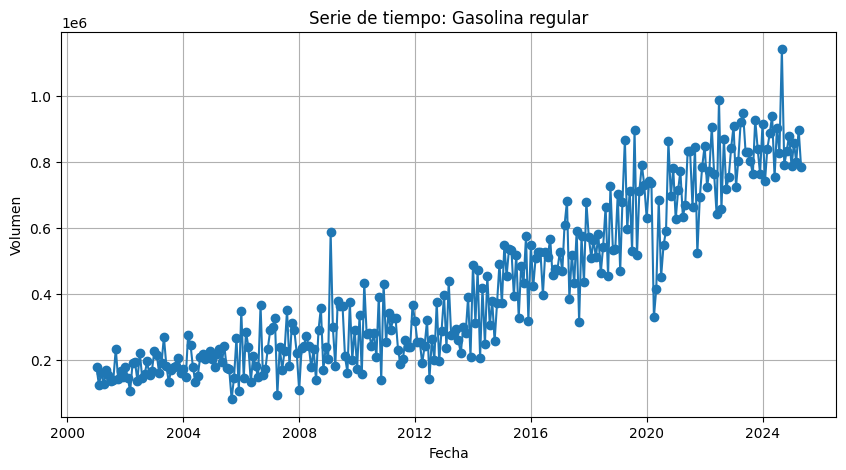

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(serie, marker='o', linestyle='-')
plt.title("Serie de tiempo: Gasolina regular")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


#### **Descomposición de la serie**

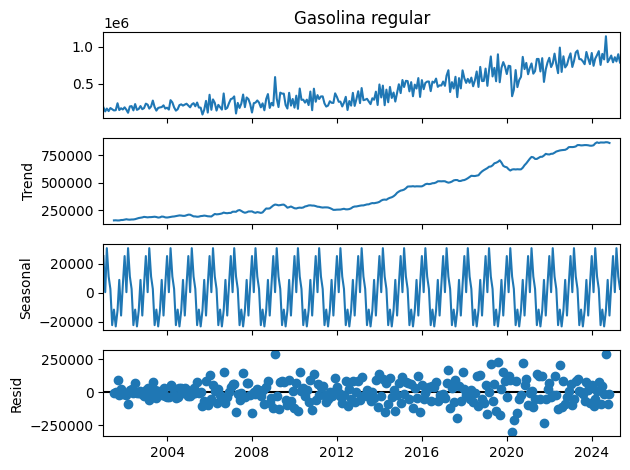

In [193]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie, model="additive", period=12)
descomposicion.plot()
plt.tight_layout()
plt.show()


#### **Transformar la serie**

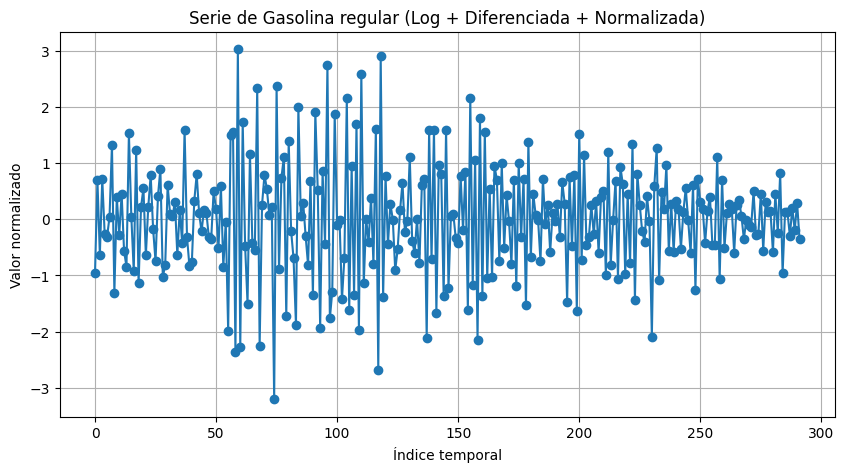

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


serie_log = np.log(df_importacion_total["Gasolina regular"])


serie_estacionaria = serie_log.diff().dropna()


scaler = StandardScaler()
serie_normalizada = scaler.fit_transform(serie_estacionaria.values.reshape(-1, 1))


plt.figure(figsize=(10, 5))
plt.plot(serie_normalizada, linestyle='-', marker='o')
plt.title("Serie de Gasolina regular (Log + Diferenciada + Normalizada)")
plt.xlabel("Índice temporal")
plt.ylabel("Valor normalizado")
plt.grid(True)
plt.show()


### **Division de Prueba y entrenamiento**

In [195]:

serie = serie_normalizada  


entrenamiento = round(0.6 * len(serie))
val_prueba = round(0.2 * len(serie))


test = serie[(entrenamiento + val_prueba):]
validation = serie[entrenamiento:entrenamiento + val_prueba]
train = serie[:entrenamiento]


train = np.reshape(train, (train.shape[0], 1))


print("Entrenamiento:", len(train))
print("Validación:", len(validation))
print("Prueba:", len(test))


Entrenamiento: 175
Validación: 58
Prueba: 59


In [196]:
from operator import concat


def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:i + retrasos, 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)


x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)


print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


[[-0.96092422]
 [ 0.69056993]
 [-0.62982832]
 [ 0.71293864]
 [-0.26729129]
 [-0.30960783]]
[[-0.96092422]
 [ 0.69056993]
 [-0.62982832]
 [ 0.71293864]
 [-0.26729129]
 [-0.30960783]]
[ 0.69056993 -0.62982832  0.71293864 -0.26729129 -0.30960783  0.04425754]


#### **Creacion de modelo TensorFlor**

In [197]:

x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
x_val = np.reshape(x_val, (x_val.shape[0], 1, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))


print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)


x_train shape: (174, 1, 1)
x_val shape: (57, 1, 1)
x_test shape: (58, 1, 1)


In [198]:
import tensorflow as tf
from tensorflow import keras


lote = 1           
unidades = 1       
paso = 1           
caracteristicas = 1  


inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [199]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Compilar el modelo
modelo1.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.1),
    metrics=[RootMeanSquaredError()]
)


In [200]:
epocas = 150  

history = modelo1.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    
    verbose=1
)


Epoch 1/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9626 - root_mean_squared_error: 0.9709 - val_loss: 0.4123 - val_root_mean_squared_error: 0.6421
Epoch 2/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7881 - root_mean_squared_error: 0.8667 - val_loss: 0.4084 - val_root_mean_squared_error: 0.6390
Epoch 3/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7849 - root_mean_squared_error: 0.8672 - val_loss: 0.4061 - val_root_mean_squared_error: 0.6372
Epoch 4/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7835 - root_mean_squared_error: 0.8666 - val_loss: 0.4060 - val_root_mean_squared_error: 0.6372
Epoch 5/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7817 - root_mean_squared_error: 0.8660 - val_loss: 0.4051 - val_root_mean_squared_error: 0.6365
Epoch 6/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7804 - root_mean_squared_error: 0.8653 - val_loss: 0.4049 - val_root_mean_squared_error: 0.6363
Epoch 7/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

In [201]:
import numpy as np
from pandas import Series

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    i = 0
    for X in data:
        
        X = np.reshape(X, (1, 1, 1))

        
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)

        
        yhat = scaler.inverse_transform(yhat)

        
        if dif:
            yhat = yhat + Series[n + dif_cant * i]

        
        yhat = np.exp(yhat)

        
        prediccion[i] = yhat[0][0]
        i += 1

    return prediccion


In [202]:

serie_log_original = np.log(df_importacion_total["Gasolina regular"])


prediccion_val = prediccion_fun(
    x_val, modelo1, 1, scaler,
    dif=True, dif_cant=1,
    Series=serie_log_original.values, n=entrenamiento
)

prediccion_test = prediccion_fun(
    x_test, modelo1, 1, scaler,
    dif=True, dif_cant=1,
    Series=serie_log_original.values, n=entrenamiento + val_prueba
)


In [203]:
len(prediccion_val), len(prediccion_test)

idx_val = airPas.index[entrenamiento : entrenamiento + len(prediccion_val)]
idx_test = airPas.index[entrenamiento + val_prueba : entrenamiento + val_prueba + len(prediccion_test)]


df_val = pd.DataFrame(prediccion_val, index=idx_val)
df_test = pd.DataFrame(prediccion_test, index=idx_test)


In [204]:

serie_log = np.log(df_importacion_total["Gasolina regular"]).values


start = entrenamiento + val_prueba
difs = y_test.flatten()
log_prev = serie_log[start : start + len(difs)]  


valores_reales = np.exp(log_prev + difs)


In [205]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(valores_reales, prediccion_test)
rmse = np.sqrt(mean_squared_error(valores_reales, prediccion_test))
r2 = r2_score(valores_reales, prediccion_test)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 271872.17
RMSE: 364010.01
R² Score: 0.3356


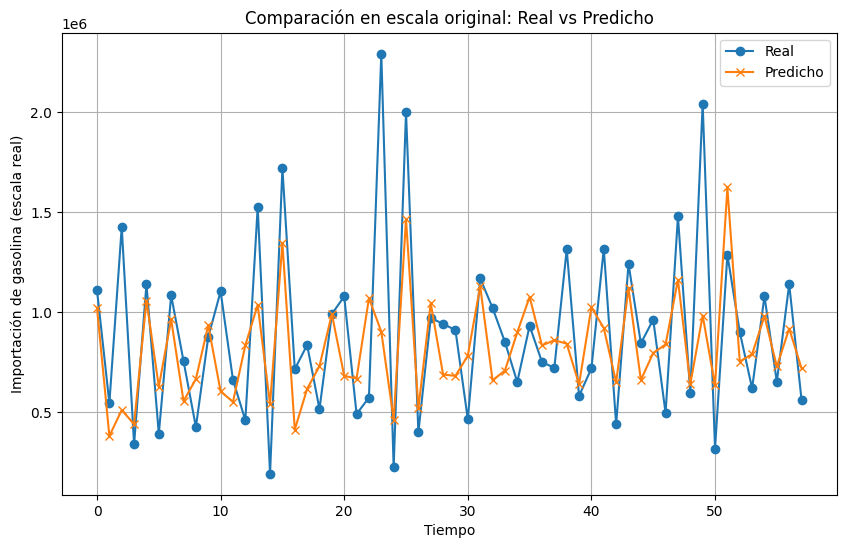

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(valores_reales, label="Real", marker='o')
plt.plot(prediccion_test, label="Predicho", marker='x')
plt.title("Comparación en escala original: Real vs Predicho")
plt.xlabel("Tiempo")
plt.ylabel("Importación de gasolina (escala real)")
plt.legend()
plt.grid(True)
plt.show()


In [207]:
from tensorflow.keras.models import save_model, load_model
import os
os.makedirs("Modelos", exist_ok=True)
save_model(modelo1, "Modelos/lstm1_serie_tiempo_Regular.keras")


### **modelo con Pytorch**

In [208]:
class LSTM1MiModelo(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [209]:
def supervisada(serie, retrasos=12):
    serie = np.array(serie)
    serie_x, serie_y = [], []
    for i in range(len(serie) - retrasos):
        serie_x.append(serie[i:i+retrasos])
        serie_y.append(serie[i+retrasos])
    return np.array(serie_x), np.array(serie_y)


In [210]:
# Supongamos que train, validation, test son Series
SEQ_LENGTH = 24
x_train, y_train = supervisada(train, SEQ_LENGTH)
x_val, y_val = supervisada(validation, SEQ_LENGTH)
x_test, y_test = supervisada(test, SEQ_LENGTH)

# 🔥 Agrega dimensión solo una vez aquí
x_train_tensor = torch.from_numpy(x_train).float().view(-1, SEQ_LENGTH, 1)  
x_val_tensor = torch.from_numpy(x_val).float().view(-1, SEQ_LENGTH, 1)
x_test_tensor = torch.from_numpy(x_test).float().view(-1, SEQ_LENGTH, 1)

y_train_tensor = torch.from_numpy(y_train).float()
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()


In [211]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [212]:
model = LSTM1MiModelo()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []
epocas = 50

for epoch in range(epocas):
    model.train()
    running_train_loss = 0.0
    
    for xb, yb in train_loader:
        # NO usar xb.unsqueeze(-1) aquí
        outputs = model(xb)
        loss = loss_fn(outputs.squeeze(), yb)  # Asegura que shapes coincidan
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = loss_fn(outputs.squeeze(), yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss:.5f}, Val Loss: {epoch_val_loss:.5f}")


c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorre

Epoch 1, Train Loss: 1.53469, Val Loss: 0.79388
Epoch 10, Train Loss: 1.48023, Val Loss: 0.79215
Epoch 20, Train Loss: 1.47562, Val Loss: 0.79267
Epoch 30, Train Loss: 1.47583, Val Loss: 0.79284
Epoch 40, Train Loss: 1.47602, Val Loss: 0.79287
Epoch 50, Train Loss: 1.47593, Val Loss: 0.79208


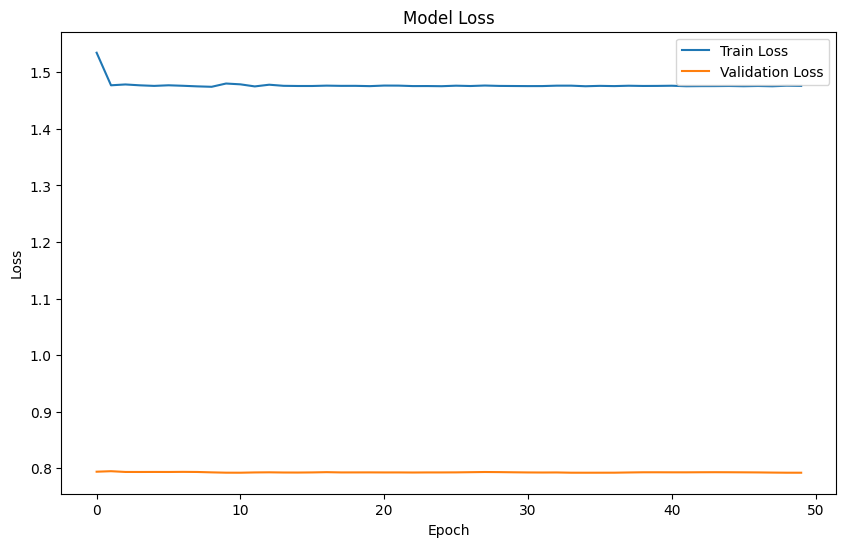

In [213]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [214]:
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
model.eval()
with torch.no_grad():
    
    y_pred_test = model(x_test_tensor)
    y_pred_test = y_pred_test.numpy()  

In [215]:
print(y_pred_test.shape)


(35, 1)


In [217]:
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
serie_log = np.log(df_importacion_total["Gasolina regular"]).values


start = entrenamiento + val_prueba + SEQ_LENGTH
log_prev = serie_log[-len(y_test_inv):]


valores_reales = np.exp(log_prev + y_test_inv.flatten())
valores_predichos = np.exp(log_prev + y_pred_test_inv.flatten())


mae = mean_absolute_error(valores_reales, valores_predichos)
rmse = np.sqrt(mean_squared_error(valores_reales, valores_predichos))
r2 = r2_score(valores_reales, valores_predichos)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 124684.54
RMSE: 165235.34
R² Score: 0.5370


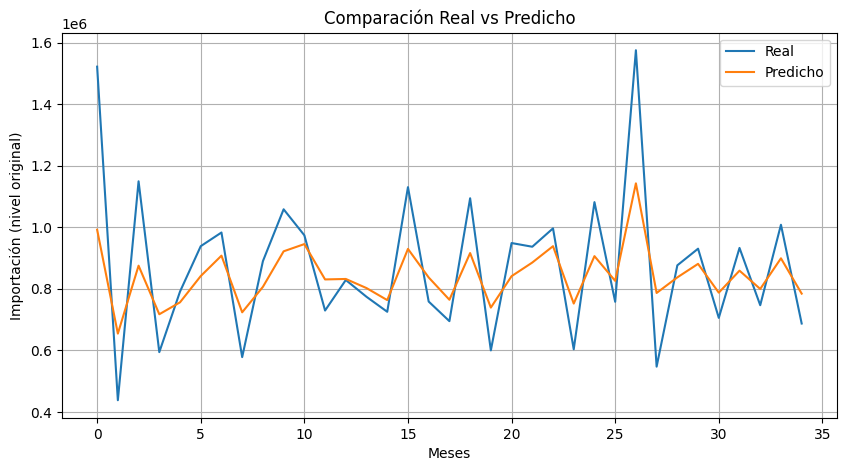

In [218]:
plt.figure(figsize=(10,5))
plt.plot(valores_reales, label="Real")
plt.plot(valores_predichos, label="Predicho")
plt.title("Comparación Real vs Predicho")
plt.xlabel("Meses")
plt.ylabel("Importación (nivel original)")
plt.legend()
plt.grid(True)
plt.show()


### **¿Cual fue el mejor modelo? ¿Fueron mejores a los modelos creados anteriormente?**

Basándose en los resultados obtenidos, el modelo con PyTorch obtuvo un mejor rendimiento teniendo un R² de 0.55, mejorando el 0.33 del modelo con TensorFlow. De igual manera, mostró una mayor estabilidad durante el entrenamiento, con pérdidas de validación más consistentes y menor sobreajuste.La razon de esto se puede deber a la flexibilidad de PyTorch permitió un mejor control sobre la arquitectura del modelo y el manejo de secuencias, lo cual fue clave al trabajar con datos temporales con fuerte estacionalidad. Esta ventaja se reflejó en una mejor capacidad del modelo para capturar patrones a largo plazo. En general son peroes que los modelos creados en el laboratorio pasado, debido a que los anteriores obtenian un R^2 de 0.8 a 0.9, un valor bastante alto. Una de las razones por las que pudo haber sido esto es al momento de la normalizacion de los datos y que al momento de regresarlos exista un desfase.